# Initializatoin

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# cd /content/drive/MyDrive/Colab\ Notebooks/Deep\ Learning\ Course/HW03

In [3]:
!cp /kaggle/input/name-dataset/name_dataset.py ./

## Imports

In [4]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.nn import Parameter

from name_dataset import Dataset

# RNN

## Traditional RNN

In the introductory section, we delve into the architecture of Recurrent Neural Networks (RNNs) and elucidate their training methodologies. To gain a deeper understanding of RNNs, you're encouraged to explore further [HERE](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-network)

For the task at hand, you've been furnished with the Names dataset, a compilation comprising thousands of surnames from 18 distinct languages of origin. Your objective is to prognosticate the language of origin for a given name, relying solely on its orthography. Your task primarily involves implementing the section demarcated by `#your_code`.

In [5]:
dataset = Dataset()
for i in range(10):
    category, line, _, _ = dataset.randomTrainingExample()
    print("category =", category, "- random name =", line)

Error occurred while downloading data.zip: --2024-04-21 21:22:04--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.106, 99.86.38.72, 99.86.38.96, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: 'data.zip'

     0K .......... .......... .......... .......... ..........  1% 4.40M 1s
    50K .......... .......... .......... .......... ..........  3% 24.3M 0s
   100K .......... .......... .......... .......... ..........  5% 13.2M 0s
   150K .......... .......... .......... .......... ..........  7% 27.6M 0s
   200K .......... .......... .......... .......... ..........  8% 26.9M 0s
   250K .......... .......... .......... .......... .......... 10% 30.6M 0s
   300K .......... .......... .......... .......... .......... 12% 35.0M 0s
   350K .......... .......... .......... ..........

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        # your_code
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden):
        # your_code
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
n_letters = dataset.n_letters
n_categories = dataset.n_categories
rnn = RNN(n_letters, n_hidden, n_categories)

In [7]:
# your_code
criterion = nn.NLLLoss()
learning_rate = 0.005


def train(category_tensor, name_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    # your_code
    for i in name_tensor:
        output, hidden = rnn(i, hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

And here you can train your model and see it's performance after each 5000 iterations

5000 5% 2.7320 Charlott is predicted as a "Russian" name, status = ✗ (Czech)
10000 10% 1.8623 Coupe is predicted as a "German" name, status = ✗ (French)
15000 15% 2.2787 Dopita is predicted as a "Japanese" name, status = ✗ (Czech)
20000 20% 0.1347 Chanchikov is predicted as a "Russian" name, status = ✓
25000 25% 0.4161 Dasios is predicted as a "Greek" name, status = ✓
30000 30% 1.5968 Close is predicted as a "Greek" name, status = ✓
35000 35% 2.3913 Baba is predicted as a "Spanish" name, status = ✗ (Arabic)
40000 40% 0.8863 Romao is predicted as a "Portuguese" name, status = ✓
45000 45% 0.5038 Deng is predicted as a "Chinese" name, status = ✓
50000 50% 1.2115 Franco is predicted as a "Italian" name, status = ✗ (Portuguese)
55000 55% 2.0392 Tindell is predicted as a "Irish" name, status = ✗ (English)
60000 60% 0.6341 Law is predicted as a "Chinese" name, status = ✓
65000 65% 2.1178 Miller is predicted as a "English" name, status = ✗ (Scottish)
70000 70% 3.5612 Shimon is predicted as a "

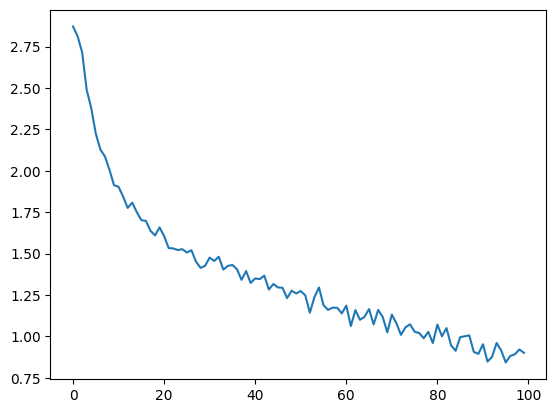

In [8]:
n_iters = 100000
print_every = 5000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = dataset.randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, _ = dataset.categoryFromOutput(output)
        correct = "✓" if guess == category else "✗ (%s)" % category
        print(
            '%d %d%% %.4f %s is predicted as a "%s" name, status = %s'
            % (iter, iter / n_iters * 100, loss, line, guess, correct)
        )

    if iter % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

## Traditional RNN Disadvantages

In this part, we aim to delve into the limitations of traditional RNNs:
1.   Recurrent computation is slow
2.   They have difficulty accessing information from many steps back.

You are provided with a simple code that helps you to give the idea better. By modifying this code, you are able to demonstrate the mentioned disadvantages, but you are also free to change the code if needed or use any dataset you want.

**Question:** Do you think using GPU instead of CPU completely solves the first problem?

Note: The main goal of this part is to help you understand these problems better. Don't be too hard to implement and delivery.

Epoch [10/100], Loss: 1.1027
Epoch [20/100], Loss: 1.0394
Epoch [30/100], Loss: 0.9763
Epoch [40/100], Loss: 0.9088
Epoch [50/100], Loss: 0.8328
Epoch [60/100], Loss: 0.7441
Epoch [70/100], Loss: 0.6385
Epoch [80/100], Loss: 0.5123
Epoch [90/100], Loss: 0.3715
Epoch [100/100], Loss: 0.2394


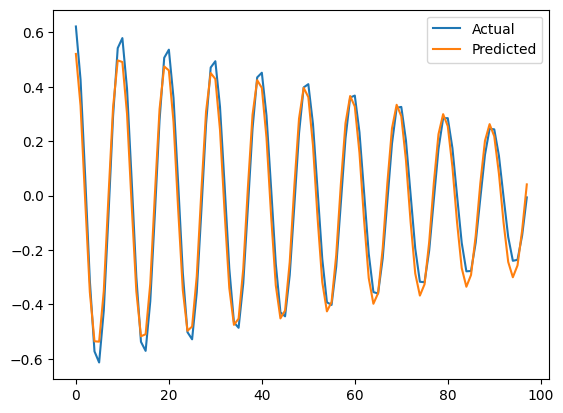

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Generate sinusoidal temperature data with decreasing range over time
np.random.seed(0)
num_periods = 50
timesteps_per_period = 10
total_timesteps = num_periods * timesteps_per_period

# Generate decreasing factor
decreasing_factor = np.linspace(1, 0.1, total_timesteps)

# Generate temperature data with decreasing sinusoidal range
temperature_data = (
    np.sin(np.linspace(0, 2 * np.pi * num_periods, total_timesteps)) * decreasing_factor
)

# Normalize the data
temperature_data = (temperature_data - np.mean(temperature_data)) / np.std(
    temperature_data
)

# Convert numpy array to PyTorch tensor
temperature_data = torch.tensor(temperature_data, dtype=torch.float32).view(-1, 1)


# Define function to create dataset with sinusoidal pattern
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        seq_in = data[i : i + seq_length]
        seq_out = data[i + seq_length]
        X.append(seq_in)
        Y.append(seq_out)
    return torch.stack(X), torch.stack(Y)


# Define sequence length and create dataset
sequence_length = 10  # Number of previous days to look at for prediction
X, Y = create_dataset(temperature_data, sequence_length)

# Split the dataset into train and test sets
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


# Define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


# Define model parameters
input_size = 1
hidden_size = 10
output_size = 1

# Instantiate the model
model = SimpleRNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

# Plot actual vs predicted
plt.plot(Y_test.numpy(), label="Actual")
plt.plot(test_predictions.numpy(), label="Predicted")
plt.legend()
plt.show()

# LSTM Preparation

Now that you have experience with traditional RNNs, it's time to implement the LSTM model. Your goal is to implement the cell and model for LSTM architecture. The proposed dataset for this section is MNIST, allowing you to focus solely on model implementation.

In [9]:
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transforms.ToTensor()
)

batch_size = 128
n_iters = 6000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

100%|██████████| 9912422/9912422 [00:00<00:00, 152543987.48it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 46323401.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41601598.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16465452.69it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

## LSTM Cells

In [11]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: (batch_size, input_size)
        #       hx: (batch_size, hidden_size)
        # Outputs:
        #       hy: (batch_size, hidden_size)
        #       cy: (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
            hx = (hx, hx)

        hx, cx = hx

        # your code
        gates = self.xh(input) + self.hh(hx)
        input_gate, forget_gate, cell_gate, output_gate = gates.squeeze().chunk(4, 1)

        i_t = F.sigmoid(input_gate)
        f_t = F.sigmoid(forget_gate)
        g_t = F.tanh(cell_gate)
        o_t = F.sigmoid(output_gate)

        cy = f_t * cx + i_t * g_t
        hy = o_t * F.tanh(cy)

        return (hy, cy)

## LSTM Models

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)



    def forward(self, x):

        # Initialize hidden state with zeros
        c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        h0 = h0.to(device)
        c0 = c0.to(device)

        cn = c0[0,:,:]
        hn = h0[0,:,:]
        outs = []

        for seq in range(x.size(1)):
            # your code
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))
            outs.append(hn)

        #your code
        out = self.fc(outs[-1])
        return out

In [14]:
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY 1 OR 2
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# your code
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [15]:
# your code
# Train model and print Loss and Accuracy on Test Dataset after each 500 iterations


def train_network(
    model,
    criterion,
    train_loader,
    sequence_length=28,
    input_dim=28,
    test_loader=None,
    epochs=50,
    device="cpu",
    optimizer=None,
    log_interval=None,
):
    iter_count = 0
    results = {
        "train_loss": [],
        "test_loss": [],
    }
    
    model.to(device)
    for _ in range(epochs):
        for inputs, labels in train_loader:
            model.train()
            inputs = inputs.to(device)
            labels = labels.to(device)

            inputs = inputs.reshape(-1, sequence_length, input_dim)

            y_hat = model(inputs)
            loss = criterion(y_hat, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            results["train_loss"].append(loss.item())

            iter_count += 1
            if iter_count % log_interval == 0:
                model.eval()
                with torch.no_grad():
                    n_correct = 0
                    for inputs, labels in test_loader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        inputs = inputs.reshape(-1, sequence_length, input_dim)

                        y_hat = model(inputs)
                        loss = criterion(y_hat, labels)
                        results["test_loss"].append(loss.item())

                        y_pred = torch.argmax(y_hat, dim=1)
                        n_correct += torch.sum(y_pred == labels).item()
                    test_acc = n_correct / len(test_loader.dataset)
                    print(
                        f"[iteration {iter_count:4}]:  test loss = {loss:.4f}, test acc = {test_acc:.4f}"
                    )

    return results

In [16]:
results = train_network(
    model,
    criterion,
    train_loader,
    test_loader=test_loader,
    sequence_length=28,
    input_dim=input_dim,
    optimizer=optimizer,
    epochs=num_epochs,
    device=device,
    log_interval=500,
)

[iteration  500]:  test loss = 0.1279, test acc = 0.9455
[iteration 1000]:  test loss = 0.1217, test acc = 0.9523
[iteration 1500]:  test loss = 0.0070, test acc = 0.9673
[iteration 2000]:  test loss = 0.0032, test acc = 0.9754
[iteration 2500]:  test loss = 0.0029, test acc = 0.9701
[iteration 3000]:  test loss = 0.0099, test acc = 0.9768
[iteration 3500]:  test loss = 0.0011, test acc = 0.9803
[iteration 4000]:  test loss = 0.0050, test acc = 0.9828
[iteration 4500]:  test loss = 0.0023, test acc = 0.9804
[iteration 5000]:  test loss = 0.0035, test acc = 0.9826
[iteration 5500]:  test loss = 0.0902, test acc = 0.9856


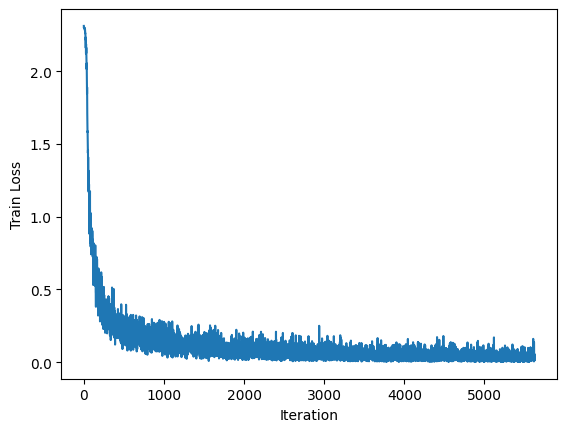

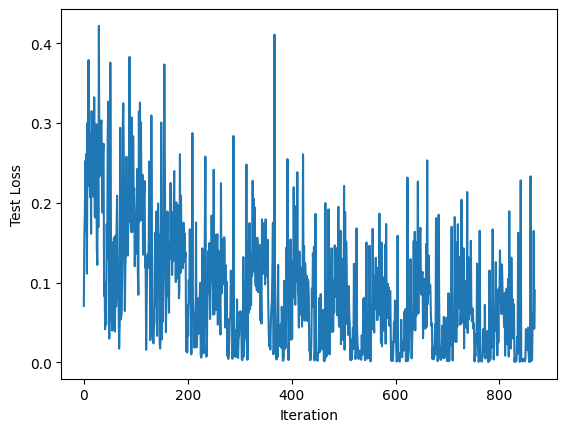

In [17]:
plt.plot(results["train_loss"])
plt.xlabel('Iteration')
plt.ylabel('Train Loss')
plt.show()

plt.plot(results["test_loss"])
plt.xlabel('Iteration')
plt.ylabel('Test Loss')
plt.show()

# Sentiment Analysis

Now you are ready to face a real-world problem. In this task, we want you to do a sentiment analysis on the [IMDB dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). The main goal is to reach more than an acceptable accuracy of **75%** on LSTM model. You are free to use torch.nn.LSTM to design your architecture, but you must prepare the IMDB dataset on your own.